# Lecture III: Recurrent Neural Network
This homework aims to help you understand Recurrent Neural Network by building a RNN classifier on Japanese Vowels from different male speakers. 

As usual, we will first import some useful modules:

In [2]:
# pylint: disable=E1101,R,C
import numpy as np
import os
import argparse
import time
import math
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.parameter import Parameter
from torch.nn import init
import torch.nn.functional as F
import torch.utils.data as data_utils
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.autograd import Variable
import gzip
import pickle
from scipy import sparse
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.cuda.amp import autocast 
torch.set_default_tensor_type(torch.FloatTensor)

The Japanese Vowel dataset can be found [here](https://archive.ics.uci.edu/ml/datasets/Japanese+Vowels). For a detailed description, please look at this website. First, we will download the dataset:

In [3]:
!python -m wget https://archive.ics.uci.edu/ml/machine-learning-databases/JapaneseVowels-mld/ae.train
!python -m wget https://archive.ics.uci.edu/ml/machine-learning-databases/JapaneseVowels-mld/ae.test
!python -m wget https://archive.ics.uci.edu/ml/machine-learning-databases/JapaneseVowels-mld/size_ae.train
!python -m wget https://archive.ics.uci.edu/ml/machine-learning-databases/JapaneseVowels-mld/size_ae.test

100% [........................................................] 496608 / 496608
Saved under ae.train
100% [........................................................] 660983 / 660983
Saved under ae.test
100% [................................................................] 27 / 27
Saved under size_ae.train
100% [................................................................] 28 / 28
Saved under size_ae.test


This dataset contains 9 male japanese speaker pronouncing the utterance /ae/. The data is decoded by Linear Predictive Coding. A detail of LPC can be found [here](https://en.wikipedia.org/wiki/Linear_predictive_coding). Each utterance contains 12 LPC basis, thus for each time index, the time series will contain 12 channels.

## Part I: Dataset

First, we will need to prepare the dataset using `Dataset()` class. Since in last home work, I have gone through the detail of this class, I will skip most of the technical details.

time <class 'numpy.ndarray'> [[ 7.07889e-01 -1.00922e-01  7.36600e-02 -7.00594e-01 -1.21990e-01
  -6.41534e-01  1.21600e-02  2.94513e-01 -6.95900e-02 -1.71439e-01
  -2.76180e-02  1.23416e-01]
 [ 6.27659e-01 -6.27600e-02  1.49610e-02 -6.76720e-01 -5.36020e-02
  -6.12218e-01  2.48290e-02  2.60416e-01 -1.13063e-01 -2.14072e-01
  -3.89400e-02  1.24756e-01]
 [ 4.99002e-01 -7.10790e-02  5.52490e-02 -6.87276e-01  5.13080e-02
  -5.24841e-01 -1.99060e-02  2.06343e-01 -1.33993e-01 -2.66033e-01
  -5.94370e-02  1.64918e-01]
 [ 3.99139e-01 -2.41454e-01  1.13350e-01 -6.26805e-01  1.32453e-01
  -4.69094e-01 -6.70430e-02  1.17982e-01 -1.73991e-01 -3.10972e-01
  -3.20450e-02  2.51694e-01]
 [ 3.15763e-01 -2.95425e-01  1.07049e-01 -5.15065e-01  1.93741e-01
  -4.23867e-01 -8.96280e-02  2.52610e-02 -2.27016e-01 -3.30753e-01
   1.03410e-02  2.88242e-01]
 [ 3.34036e-01 -3.82180e-01  1.04048e-01 -4.68691e-01  2.19107e-01
  -3.83486e-01 -6.98350e-02 -4.81840e-02 -2.72903e-01 -3.26816e-01
   3.44300e-03  3.2600

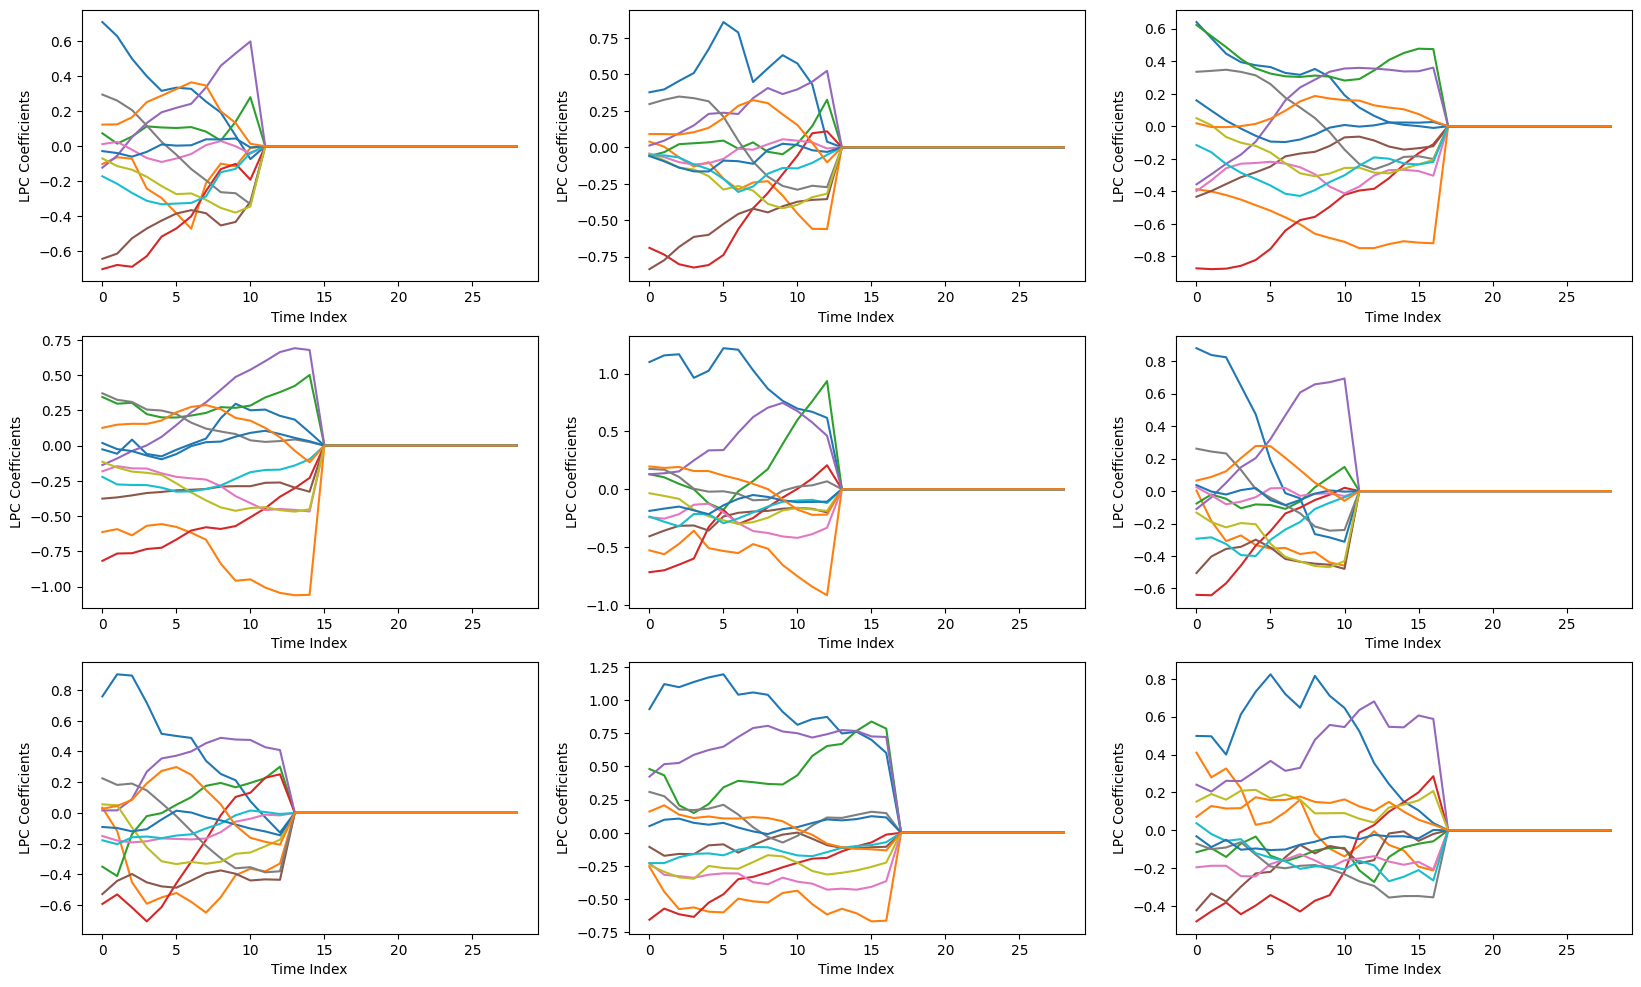

In [ ]:
class JapaneseVowelDataset(Dataset):

    def __init__(self,plot=True):
        
        self.max_length = 29 # The maximum possible length of each utterance contains 29 samples
        self.num_LPC = 12    # The LPC spectrum contains 12 coefficients, so the data shape will be [29,12]
          #LPC is a speech extraction feature do i need it anyways for my wave forms?
        
        train_data, train_label = self.read_vowels("Data/ae.train","Data/size_ae.train") #We are adding data here to train
        test_data, test_label = self.read_vowels("Data/ae.test","Data/size_ae.test")
        
        
        self.size = len(train_data) + len(test_data)
        self.train_test_split = len(train_data)
        
        #print(len(train_data))
        self.data = train_data + test_data
        #print(self.data)
        # print("waves", type(self.data), self.data[0])
        self.labels = train_label + test_label
       # print("time", type(self.labels), self.labels)
        if plot:
            self.plot_data()
        
        
    def __len__(self):
        '''
        This function returns the size of overall dataset
        '''
        return self.size


    def __getitem__(self, idx):
        '''
        This function extract a single entry from the dataset at the given index idx
        In this dataset, the data has variable length, so we need to pad 
        the LPC coefficients to have the same length for training purpose
        '''
        output = np.zeros((self.max_length, self.num_LPC))
        data = self.data[idx]
        output[:data.shape[0]] += data
        #print(type(output[0]))
        #print(output)
        return output, self.labels[idx]
       
    
    def get_train_test_split(self):
        '''
        This function get the train test split size of the dataset
        '''
        return self.train_test_split
    
    def read_vowels(self, file, size_file):
        vowel_units = []
        speaker_size = []
        labels = []
        #Read out the LPC value of all vowels
        with open(file, "r") as f:
            current_vowel = []
            for line in f.readlines():
                if line == '\n':
                    vowel_units.append(np.array(current_vowel))
                    current_vowel = []
                    continue
                current_vowel.append(np.array(line.strip().split(" "),dtype=float).tolist())
        #Read out the size of samples by 9 speakers
        with open(size_file, "r") as f:
            speaker_size = np.array(f.readline().strip().split(" "),dtype=int)
            assert len(speaker_size) == 9 # If speaker size is not 9, then there's something wrong
        #Assign a label to each speaker, speaker 1 == 0 .....speaker 9 == 8:
        for speaker_label in range(9):
            labels += [speaker_label] * speaker_size[speaker_label]
        # Check if the number of label equals to number of data
        # If not, there is something wrong
        assert len(vowel_units) == len(labels)
        return vowel_units, labels
            
                    
        
    
    def plot_data(self):
        '''
        This function plots the LPC spectrum of 9 random utterances
        '''
        plt.figure(figsize=(20,12))
        sample_index = np.random.randint(low=0,high=self.__len__(), size = 9)
        for i in range(9):
            plt.subplot(3,3, i+1)
            voice, label = self.__getitem__(sample_index[i])
            utt_length = voice.shape[0]
            for i in range(voice.shape[-1]):
                plt.plot(np.arange(utt_length), voice[:,i])
            plt.xlabel("Time Index")
            plt.ylabel("LPC Coefficients")
            #print("sss", utt_length) i have 250 it has 29 (numpy.ndarray)
            print("time", type(voice), voice) #np.ndarray
          
JapaneseVowelDataset()

Similarly, we can check the form of data by plotting the LPC spectrum coefficients. The trailing 0s comes from the padding we performed within the dataset:

## Part II: Recurrent Neural Network
In this part, we will buid an LSTM based recurrent neural network model to analyze the input LPC spectrum. Since this is the second time we build a NN, I will leave most of the work to you. Some useful resources include:
- [nn.LSTM](https://pytorch.org/docs/master/generated/torch.nn.LSTM.html#lstm)
- [nn.Linear](https://pytorch.org/docs/master/generated/torch.nn.Linear.html?highlight=linear#torch.nn.Linear)
- [nn.LeakyReLU](https://pytorch.org/docs/master/generated/torch.nn.LeakyReLU.html?highlight=leakyrelu#torch.nn.LeakyReLU)
- [nn.Sequential](https://pytorch.org/docs/master/generated/torch.nn.Sequential.html?highlight=sequential#torch.nn.Sequential)

Some useful tips for building the recurrent neural network:
- Read [nn.LSTM](https://pytorch.org/docs/master/generated/torch.nn.LSTM.html#lstm) carefully, make sure you understand the input and output shape of the LSTM layer. The [nn.LSTM](https://pytorch.org/docs/master/generated/torch.nn.LSTM.html#lstm) layer outputs `output, (h_n, c_n)`:
    -  `output` has a shape of `(Seq_len,Batch_size,num_direction*hidden_size)`, it contains all intermediate hidden state outputs of the last layer. Note that there is a `batch_first` flag in LSTM input which may change the output shape to `(Batch_size,Seq_len,num_direction*hidden_size)`. If you want to select only the last hidden state, you shoud simply index the `Seq_len` dimension.
    -  `(h_n, c_n)` contains the last hidden state outputs of each layers
- Remember that you want to select only the the **last hidden state output**. You can either extract it from `output` or `h_n`.
- Then you will feed the **last hidden state output** into `self.fc_classifier`. You will need to adjust the `hidden_size` of LSTM output and the input size of first fully connected layer in `self.fc_classifier` to match
- Make sure the output of RNN model has the shape of [BATCHSIZE,9], since we have 9 speakers in the dataset we'd like to classify into

In [5]:
'''
This script contains the PositionalUNet network along with 3 candidate discriminators:
* RNN+Attention discriminator
* CNN+PositionalEncoding Discriminator
* Fully Connected Discriminators
we have tested all 3 discriminators, turns out that the RNN+Attention works the best
'''

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.parameter import Parameter
from torch.nn import init
import torch.nn.functional as F
import math



class DoubleConv(nn.Module):

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv1d(in_channels, mid_channels, kernel_size=11, padding=5,bias=False),
            nn.BatchNorm1d(mid_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv1d(mid_channels, out_channels, kernel_size=7, padding=3,bias=False),
            nn.BatchNorm1d(out_channels),
            nn.LeakyReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):

    def __init__(self, in_channels, out_channels, pool=True):
        super().__init__()
        self.pool = pool
        self.pool_layer = nn.MaxPool1d(2)
        self.maxpool_conv = nn.Sequential(
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        if self.pool:
            x = self.pool_layer(x)
        return self.maxpool_conv(x)


class Up(nn.Module):

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='linear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose1d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]

        x1 = F.pad(x1, [diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        mid_channels = int(in_channels + out_channels)//2
        self.conv = nn.Sequential(
            torch.nn.Conv1d(in_channels, mid_channels, kernel_size=1),
            torch.nn.LeakyReLU(),
            torch.nn.Conv1d(mid_channels, out_channels, kernel_size=1),
        )
    # @torchsnooper.snoop()
    def forward(self, x):
        return self.conv(x)

In [6]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.bilinear = True
        
        multi = 40
        
        self.inc = DoubleConv(12, multi) #1 instead of 12 for feeding 1 wave form at a time --> input channels 
        self.down1 = Down(multi, multi*2)
        self.down2 = Down(multi*2, multi*4)
        self.down3 = Down(multi*4, multi*8)
        factor = 2 if self.bilinear else 1
        self.down4 = Down(multi*8, multi*16 // factor,pool=False)
        
       
        
        self.up1 = Up(multi*16, multi*8 // factor, self.bilinear)
        self.up2 = Up(multi*8, multi*4 // factor, self.bilinear)
        self.up3 = Up(multi*4, multi*2 // factor, self.bilinear)
        self.up4 = Up(multi*2, multi // factor, self.bilinear)
        self.outc = OutConv(multi // factor, 2) # This 2 is number of decisions we want it to make. In the vowel case we only want 2 decisions (0/non0), in waveform case we may need more
        self.softmax = torch.nn.Softmax(dim=-1)
        #self.sigmoid = torch.Sigmoid()
    
    # @torchsnooper.snoop()
    def forward(self, x):
        x = x.transpose(1,2)
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        
        x5 = self.down4(x4)
        
        #Two inputs in the next ones because of the contraction paths 
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        output = self.outc(x)
        
        output = output.transpose(1,2)
        # output = self.softmax(output)
        output = torch.sigmoid(output)
      
        return output


Similar to what we did in Lecture 2 homework, we will pull out 1 event from the dataset, and use `torchsnooper.snoop()` to check the network structure. Before proceeding to the next part, you may want to stare at the tensor output of `torchsnooper.snoop()` carefully to understand how the data is flowing within the RNN network.

In [7]:
#Pull out 1 event from the dataset
test_event, test_label = next(iter(JapaneseVowelDataset(plot=False)))
test_event = torch.FloatTensor(test_event).unsqueeze(0) # Insert batch dimension
test_network = UNet()
print(np.shape(test_event))
print(test_network(test_event))

torch.Size([1, 29, 12])
tensor([[[0.5201, 0.5372],
         [0.5767, 0.5335],
         [0.5554, 0.5373],
         [0.5214, 0.5230],
         [0.5440, 0.5278],
         [0.5230, 0.5000],
         [0.5097, 0.5184],
         [0.5277, 0.5384],
         [0.5918, 0.4785],
         [0.5477, 0.4904],
         [0.5619, 0.5001],
         [0.5677, 0.5046],
         [0.5617, 0.5304],
         [0.5055, 0.5117],
         [0.4772, 0.5295],
         [0.4993, 0.5213],
         [0.4549, 0.5320],
         [0.4891, 0.5204],
         [0.5198, 0.5290],
         [0.5259, 0.5538],
         [0.5217, 0.5672],
         [0.5520, 0.5574],
         [0.5339, 0.5192],
         [0.5247, 0.5182],
         [0.5351, 0.5295],
         [0.5681, 0.5164],
         [0.6084, 0.5388],
         [0.5774, 0.5049],
         [0.5580, 0.5094]]], grad_fn=<SigmoidBackward0>)


## Part III: Training
After building the neural network, we train it the same way as we did in Lecture 2:

In [8]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # This says if GPU is available, use GPU, otherwise use CPU
NUM_EPOCHS =20
LEARNING_RATE =1e-3 # 1e-2 is a good learning rate for general purpose
BATCH_SIZE = 5

In [9]:
def set_up_classifier():
    classifier = UNet() # Define CNN neural network classifier
    classifier.to(DEVICE)     # Send the classifier to DEVICE as we defined earlier

    print("# of params in model: ", sum(x.numel() for x in classifier.parameters()))

    criterion = torch.nn.BCELoss()
    criterion = criterion.to(DEVICE)

    #Define the optimizer
    optimizer = torch.optim.Adam(classifier.parameters(),lr=LEARNING_RATE)
    
    return classifier, criterion, optimizer

In [10]:
dataset = JapaneseVowelDataset(plot=False)
len(dataset)

640

In [11]:
def get_dataloader():
    dataset = JapaneseVowelDataset(plot=False)
    #Get the indices of train dataset and test dataset correspondingly, indices [0:train_test_split] is the training dataset, indices [train_test_split, len(dataset)] is the test dataset.
    train_test_split = dataset.get_train_test_split()
    train_indices, val_indices = list(range(train_test_split)), list(range(train_test_split,len(dataset)))

    #Shuffle the two indices list
    np.random.shuffle(train_indices)
    np.random.shuffle(val_indices)

    # Define two subset random sampler to sample events according to the training indices
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)

    # Finally, define the loader by passing in the dataset, batch size and corresponding sampler
    # Note that the number of data in each sub-dataset might not be divisibe by the batch size, so drop_last=True drops the last batch with all the residual events.
    train_loader = data_utils.DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler, drop_last=True)
    test_loader = data_utils.DataLoader(dataset, batch_size=BATCH_SIZE,sampler=valid_sampler,  drop_last=True)
    
    return train_loader, test_loader

In [1]:
classifier, criterion, optimizer = set_up_classifier()
train_loader, test_loader = get_dataloader()

loss_values = []
accuracy_values = []
y_true = []
y_pred = []

for epoch in range(NUM_EPOCHS):
    for i, (utterances, labels) in tqdm(enumerate(train_loader)):
        
        #utterances.shape = [5,29,12]
        # SS label size = [5,29,2]
        label_array = []
        #print(np.shape(utterances))
        
        #for j in range(len(utterances)):
        #    print(j)
        #    #print(utterances[j])
        #break  
        for utt in utterances:
            #print(utt)
            first_dim = utt[:,0] != 0 # shape: (29,)
            second_dim = utt[:,0] == 0 # shape: (29,)
            label_vector = np.concatenate([first_dim[:,None], second_dim[:,None]],axis=-1)
            label_array.append(label_vector[None,:])
            #print(label_vector[None,:])
        
        labels = torch.Tensor(np.concatenate(label_array, axis=0))
        #print(labels)
        
        # print(np.shape(label_array))
        # print("lable_array", label_array)
        classifier.train() # This line set the neural network to train mode, some layers perform differently in train and test mode.
        
        utterances = utterances.to(DEVICE).float()
        labels = labels.to(DEVICE)
        #print(np.shape(utterances))
        #Train the RNN classifier
        outputs  = classifier(utterances)
        
        # Calculate loss
        loss = criterion(outputs, labels)
        
        # Back-propagate loss to update gradient
        loss.backward()
        
        # Perform gradient descent to update parameters
        optimizer.step()
        
        # reset gradient to 0 on all parameters
        optimizer.zero_grad()

    print('\rEpoch [{0}/{1}], Iter [{2}/{3}] Loss: {4:.4f}'.format(
        epoch+1, NUM_EPOCHS, i+1, len(train_loader),
        loss.item(), end=""),end="")
    loss_values.append(loss.item())
    

NameError: name 'set_up_classifier' is not defined

In [13]:
54*5

270

tensor([[[0.4946, 0.5054],
         [0.4946, 0.5054],
         [0.4946, 0.5054],
         [0.4945, 0.5055],
         [0.4946, 0.5054],
         [0.4946, 0.5054],
         [0.4946, 0.5054],
         [0.4946, 0.5054],
         [0.4946, 0.5054],
         [0.4946, 0.5054],
         [0.4946, 0.5054],
         [0.4946, 0.5054],
         [0.4946, 0.5054],
         [0.4946, 0.5054],
         [0.4947, 0.5053],
         [0.4947, 0.5053],
         [0.4947, 0.5053],
         [0.4946, 0.5054],
         [0.4946, 0.5054],
         [0.4947, 0.5053],
         [0.4947, 0.5053],
         [0.4946, 0.5054],
         [0.4946, 0.5054],
         [0.4947, 0.5053],
         [0.4947, 0.5053],
         [0.4947, 0.5053],
         [0.4947, 0.5053],
         [0.4947, 0.5053],
         [0.4947, 0.5053]]], grad_fn=<SoftmaxBackward0>)
torch.Size([1, 29, 2])


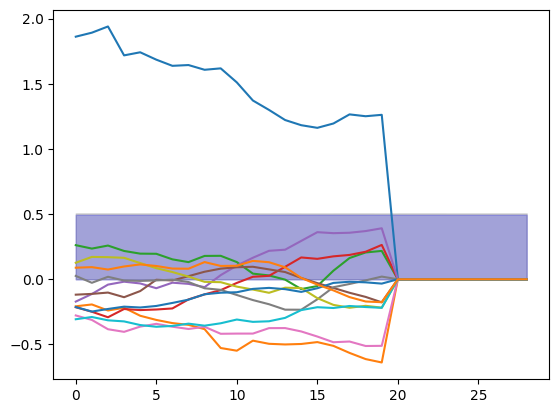

In [14]:
#Pull out 1 event from the dataset
test_event, test_label = next(iter(JapaneseVowelDataset(plot=False)))
test_event = torch.FloatTensor(test_event).unsqueeze(0) # Insert batch dimension
#print(test_event.size, test_event)
test_network = classifier
test_network.eval()
decision = torch.softmax(test_network(test_event),dim=-1)
print(decision)
print(np.shape(decision))
test_event = test_event.detach().numpy()
decision = decision.detach().numpy()
plt.plot(test_event[0,:,:])
#plt.plot(decision[0,:,:])
matplotlib.pyplot.fill_between(np.arange(29),0, decision[0,:,0], color = 'blue', alpha = 0.3)
matplotlib.pyplot.fill_between(np.arange(29),0, decision[0,:,1], color = 'grey', alpha = 0.3)
plt.show()

In [39]:
#find tr using to.interpolate and find t0-tr and plot it as a function of noise to check the spread
#area under each bins #to find charge V*t #50ohm